In [1]:
import ROOT
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import hist
import mplhep as hep

Welcome to JupyROOT 6.24/02


In [2]:
mpl.style.use(hep.style.ATLAS)
ROOT.gROOT.SetStyle('ATLAS')
ROOT.gStyle.SetOptStat(0)

# Propagazione degli errori in misure correlate e simulazione di esperimento: spettrometro a prisma
**M Sotgia<sup>1</sup>** \
_<sup>1</sup>Università degli studi di Genova, Dipartimento di Fisica_

## Introduzione

Un prisma ottico può essere utilizzato, sfruttando il fenomeno della rifrazione, come spettrometro (misuratore di lunghezza d'onda). 

Si sa che infatti la differenza $\delta_i$ tra l'angolo in ingresso $\theta_0$ e l'angolo in uscita $\theta_i$ risulta essere legato al valore dell'indice di rifrazione del materiale, $$\delta_i = \theta_0 - \alpha+\arcsin\left(n\sin\left(\alpha - \arcsin\left(\frac{\sin\theta_0}{n}\right)\right)\right),\tag{1}$$ con $n$ indice di rifrazione e $\alpha$ apertura angolare del prisma. 

Si osserva che $\delta_i$ ha un minimo in corrispondenza del quale la misura è più stabile e la relazione precedente si semplifica come $$n\sin\frac{\alpha}{2} = \sin\frac{\delta_m + \alpha}{2} = \sin\theta_{0_m}.\tag{2}$$

Possiamo anche però ricavare la relazione che lega l'indice di rifrazione $n$ al valore di $\delta_m$, e poichè $n=n(\lambda)$, secondo la relazione di Cauchy $$n(\lambda) = A + \frac{B}{\lambda^2},\tag{3} $$ appropriata ad un ordine $\mathcal O (1/\lambda^2)$, con $A$ e $B$ coefficienti propri del materiale in questione, allora possiamo concludere che esistono relazioni che legano $\lambda$ con il valore di $\delta_i$. 

## Misura sperimentale

Dal punto di vista sperimentale la misura di $\delta$ si effettua nel modo seguente

 1. si misura la direzione del raggio uscente in assenza di prisma ($\theta_0$), corrisponde ovviamente alla direzione del raggio incidente
 2. si ruota il prisma fino a trovare l'angolo di deviazione mimima  e misurare la direzione del raggio uscente ($\theta_i$)
 3. si calcola $\delta_i^m = \theta_i - \theta_0$ 

In [3]:
α = np.pi/3
λ_1 = 579.1 ## [nm] Y
λ_2 = 404.7 ## [nm] P
θ_0 = 1.5701
θ_1 = 2.6958
θ_2 = 2.7904

Δ_θ = 0.0005
ϵ_θ = Δ_θ/np.sqrt(3)

Per trovare il valore di $A$ e $B$, noti i valori di $\theta_0$, $\theta_1$ e $\theta_2$, possiamo ottenere che questi sono legati dal sistema 

$$\left\{ \begin{align*}   &n_1 \sin\left( {\alpha \over 2} \right)
  = \sin\left( {{\theta_1-\theta_0+\alpha} \over 2} \right)\\
   &n_2 \sin\left( {\alpha \over 2} \right)
  = \sin\left( {{\theta_2-\theta_0+\alpha} \over 2} \right)\\
  &n_1 = A + {B\over \lambda^2_1}\\
  &n_2 = A + {B\over \lambda^2_2}\\
  \end{align*}
 \right.\tag{4}$$
 
Trovo quindi che i coefficienti $A$ e $B$ possono essere espressi rispetto ai parametri del problema nella forma $$ \left\{
\begin{align*}
n_i &= \frac{\sin\left( {{\theta_i-\theta_0+\alpha} \over 2} \right)}{\sin\left( {\alpha \over 2} \right)} && i = 1,2 \\
A &= \frac{\lambda_1^2 n_1 - \lambda_2^2 n_2}{\lambda_1^2 - \lambda_2^2} \\
B &= \frac{n_1 - n_2}{{1\over\lambda_1^2} - {1\over\lambda_2^2}} \\
\end{align*}
\right.$$

In [4]:
def computeAB(th_0, th_1, th_2):
    
    def n_i(th_i, th_0):
        return np.sin((th_i - th_0 + α)/2)/np.sin(α/2)
    A = (n_i(th_1, th_0)*λ_1**2 - n_i(th_2, th_0)*λ_2**2)/(λ_1**2 - λ_2**2)
    B = (n_i(th_1, th_0) - n_i(th_2, th_0))/(1/(λ_1**2) - 1/(λ_2**2))
    return A, B

## Metodo _variazionale_ per trovare A, B

Possiamo considerare la variazione dei valori di $\theta_i$ nell'errore, e quindi considerare una stima dell'errore di $A$ e $B$ in questo modo. 

In [5]:
A, B = computeAB(th_0=θ_0, th_1=θ_1, th_2=θ_2)
print(f'A: {A:.5}, B: {B:.5}')

ϵ_A2 = 0
ϵ_B2 = 0

for i, j in enumerate([(1,0,0), (0,1,0), (0,0,1)]):
    r_ϵA, r_ϵB = computeAB(th_0=θ_0-j[0]*ϵ_θ, th_1=θ_1-j[1]*ϵ_θ, th_2=θ_2-j[2]*ϵ_θ)
    r_ϵA = np.abs(A - r_ϵA)
    r_ϵB = np.abs(B - r_ϵB)
    
    l_ϵA, l_ϵB = computeAB(th_0=θ_0+j[0]*ϵ_θ, th_1=θ_1+j[1]*ϵ_θ, th_2=θ_2+j[2]*ϵ_θ)
    l_ϵA = np.abs(A - l_ϵA)
    l_ϵB = np.abs(B - l_ϵB)
    
    print(f'θ_{i}\tright: A: {r_ϵA:.5}, B: {r_ϵB:.5}, \tleft A: {l_ϵA:.5}, B: {l_ϵB:.5}, \tdiff A: {r_ϵA-l_ϵA:.5}, B: {r_ϵB-l_ϵB:.5}')

A: 1.7298, B: 1.3462e+04
θ_0	right: A: 0.00014607, B: 3.9152, 	left A: 0.00014611, B: 3.9149, 	diff A: -3.6038e-08, B: 0.00028046
θ_1	right: A: 0.00026276, B: 43.036, 	left A: 0.00026269, B: 43.024, 	diff A: 7.2073e-08, B: 0.011804
θ_2	right: A: 0.00011665, B: 39.121, 	left A: 0.00011662, B: 39.109, 	diff A: 3.6036e-08, B: 0.012085


Possiamo osservare che il comportamento è lineare ad un ordine di 2, 3 cifre, quindi potrebbe essere invece ideale provare a realizzare un'analisi Monte Carlo per ottenere una propagazione degli errori più efficace

## Metodo Monte Carlo per la propagazione degli errori

Definisco quindi un numero di sampling, e valuto il valore di $A$, $B$ che ottengo considerando una distribuzione gaussiana per $\theta_i$ ($i=0,1,2$). 

In [6]:
n_samples = 1_000_000

rnd = ROOT.TRandom3(58347942)

hAB = ROOT.TH2D('', '', 100, 0, 0, 100, 0, 0)
h_AB = hist.Hist(hist.axis.Regular(100, 1.72825, 1.73125, name='A'), hist.axis.Regular(100, 13202.5, 13702.5, name='B'))

for i in range(n_samples):
    A, B = computeAB(th_0=rnd.Gaus(θ_0,ε_θ), th_1=rnd.Gaus(θ_1,ε_θ), th_2=rnd.Gaus(θ_2,ε_θ))
    h_AB.fill(A, B)
    hAB.Fill(A,B)


Text(1, 0, '')

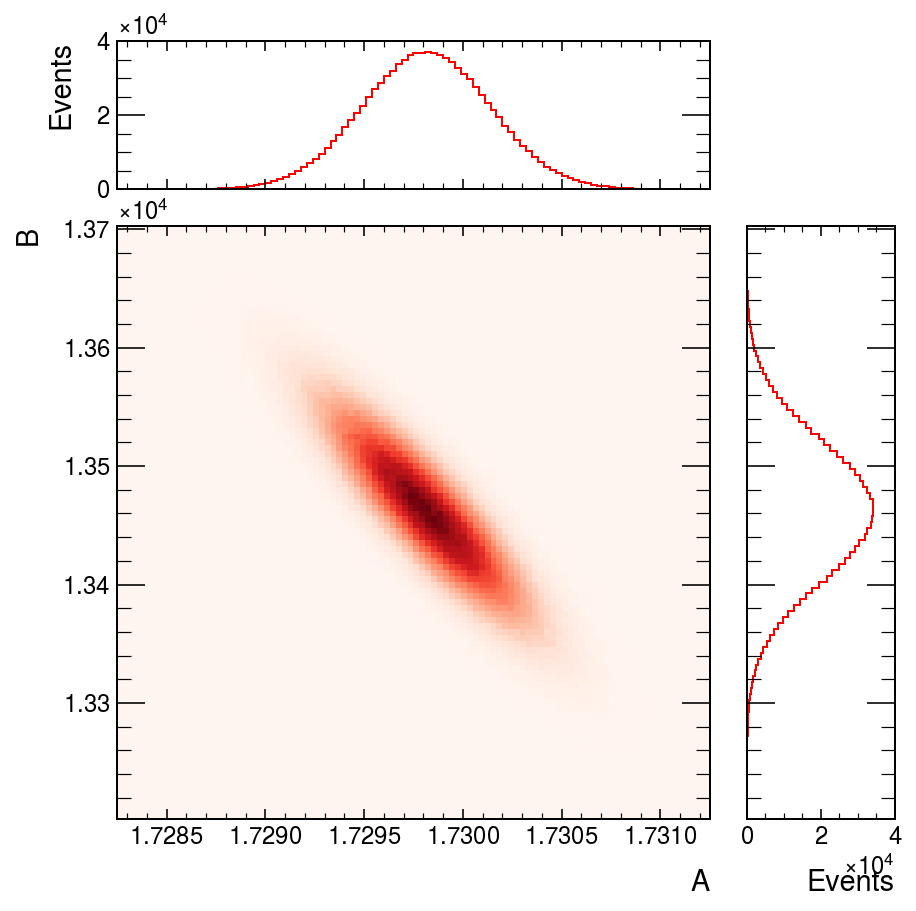

In [7]:
fig = plt.figure(figsize=(6,6))
grid = fig.add_gridspec(2,2, width_ratios=(4, 1), height_ratios=(1, 4), left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.1, hspace=0.1)

ax = fig.add_subplot(grid[1,0])
hep.hist2dplot(h_AB, ax=ax, cbar=False, cmap='Reds')

ax_x = fig.add_subplot(grid[0,0], sharex=ax)
ax_y = fig.add_subplot(grid[1,1], sharey=ax)

ax_x.tick_params(axis='x', labelbottom=False)
ax_y.tick_params(axis='y', labelleft=False)

hep.histplot(h_AB.project('A'), yerr=False, ax=ax_x, color='r')
hep.histplot(h_AB.project('B'), yerr=False, ax=ax_y, color='r', orientation='horizontal')

ax_x.set_ylabel('Events')
ax_y.set_xlabel('Events')
ax_x.set_xlabel('')

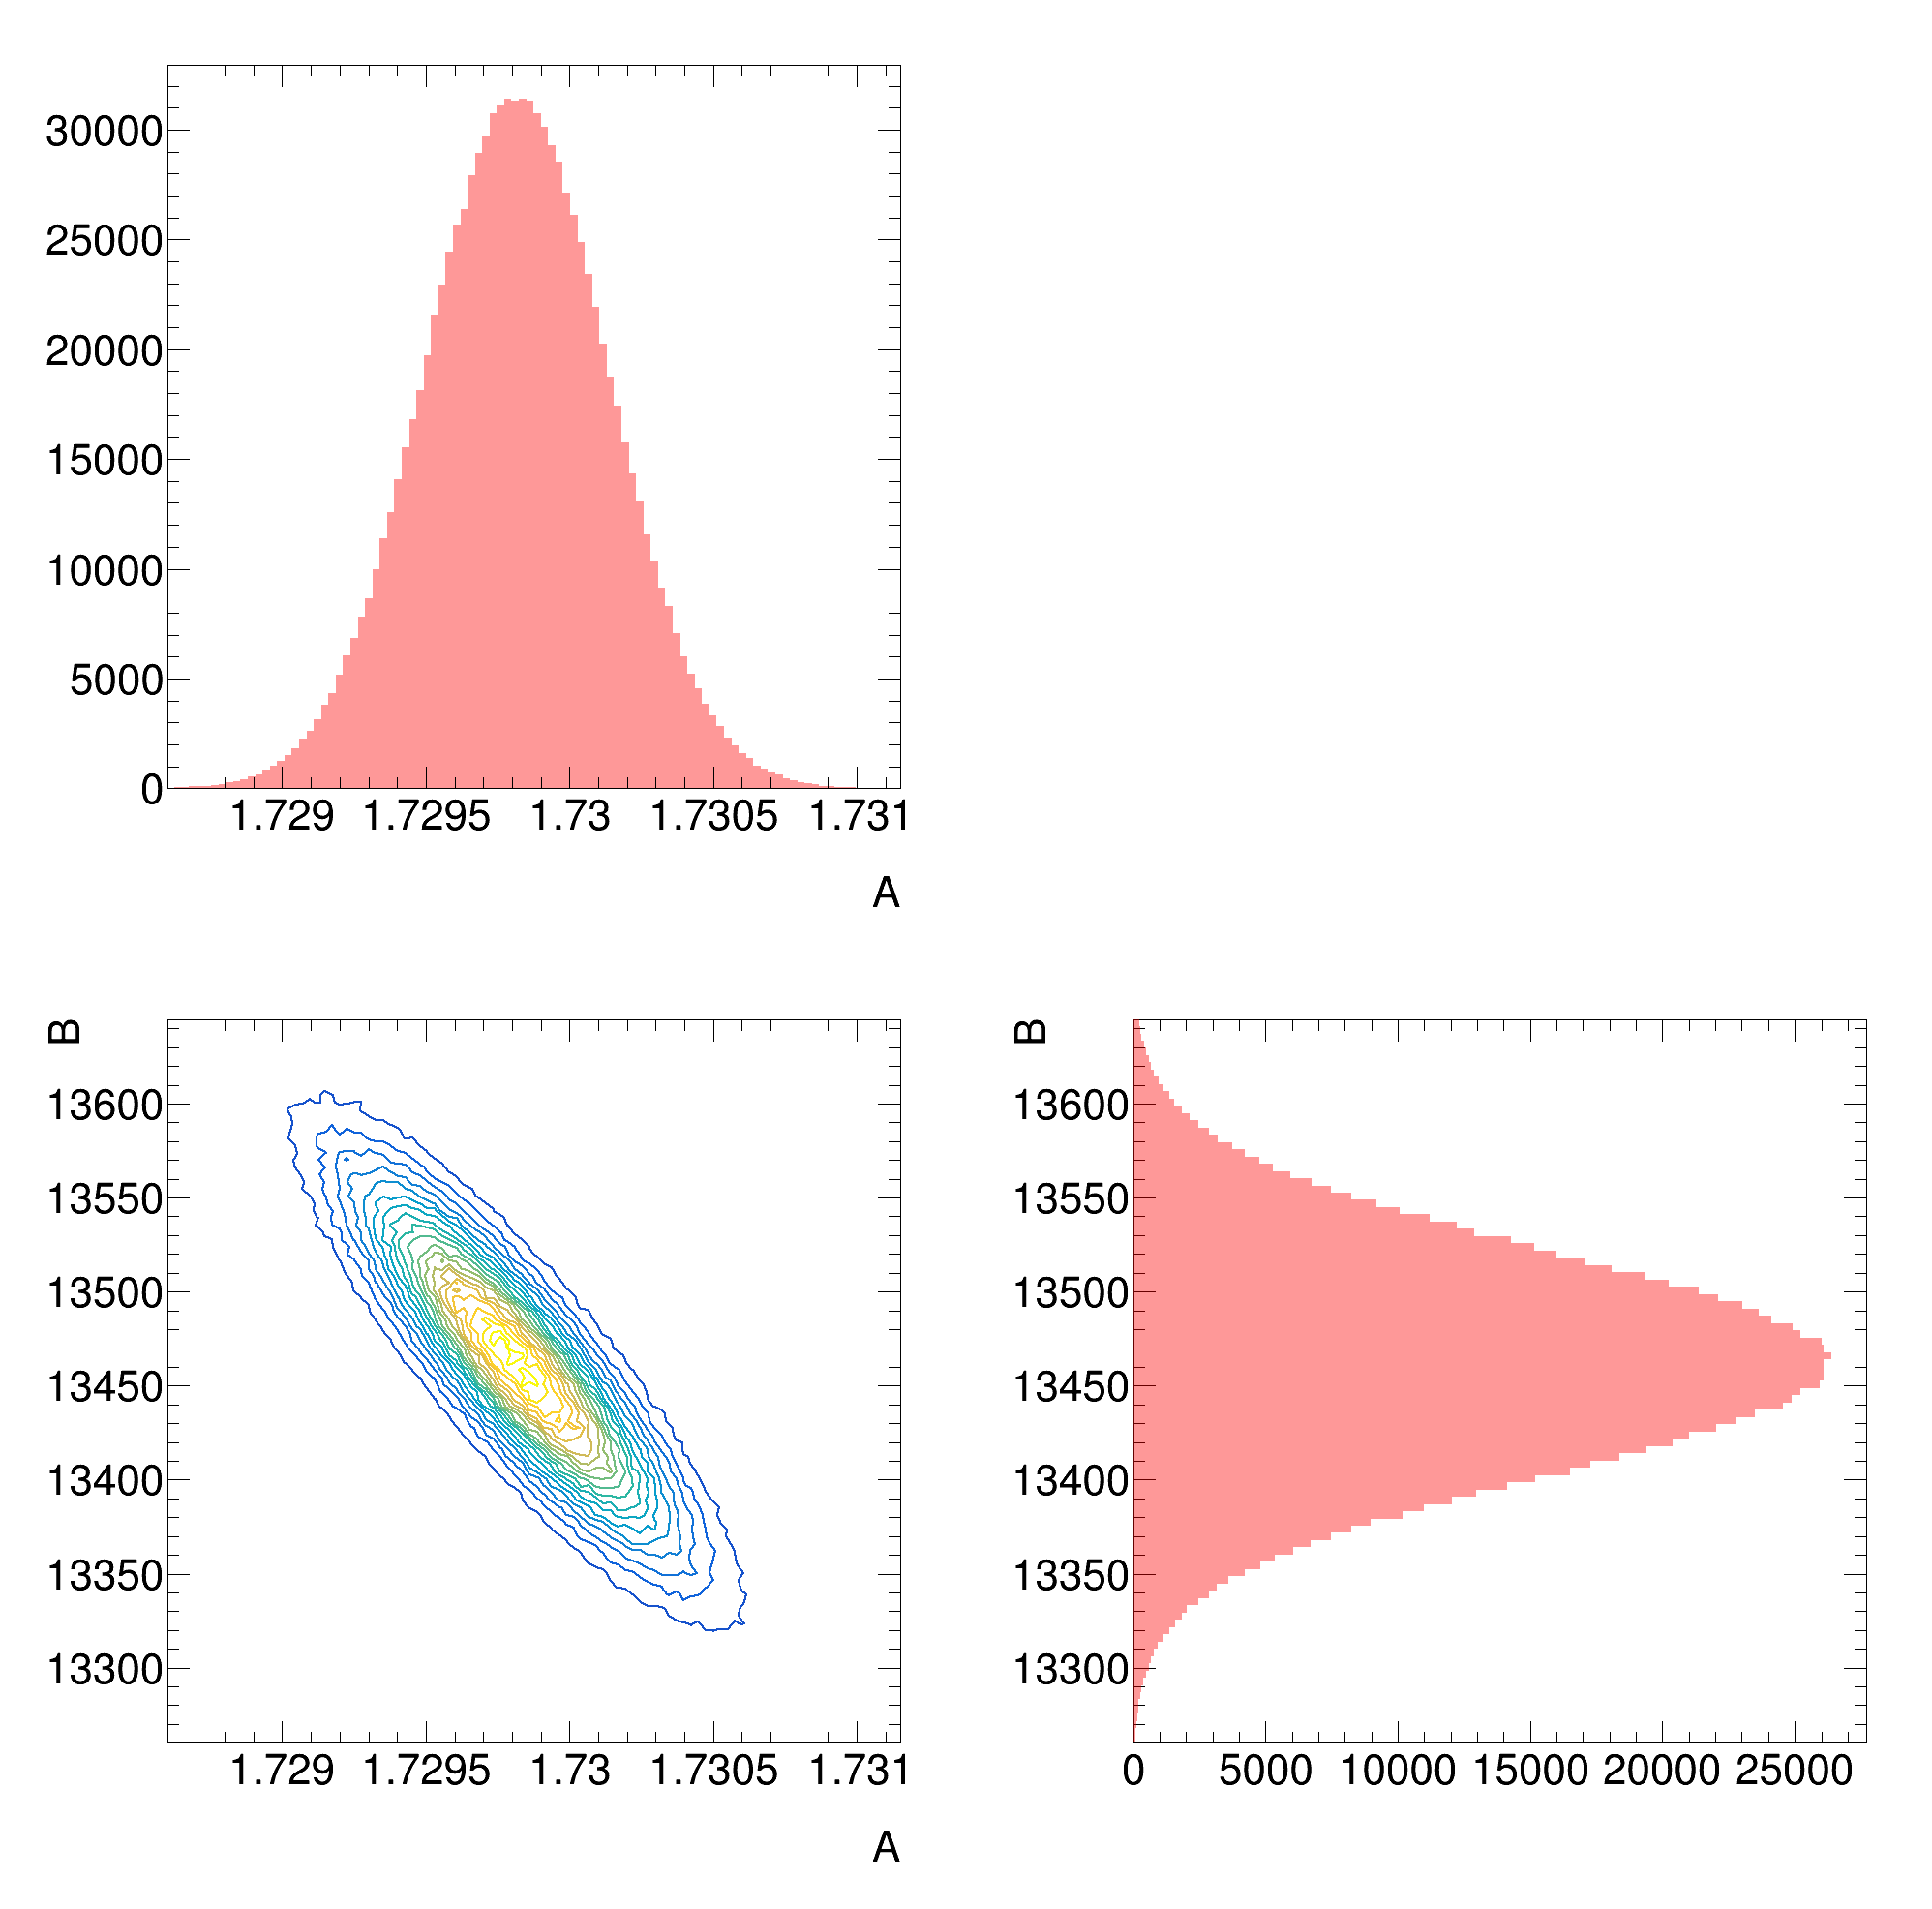

In [8]:
c = ROOT.TCanvas('', '', 2000, 2000)
c.Divide(2,2)
c.cd(3)
hAB.SetTitle(';A;B')
hAB.Draw('CONT1')
c.cd(1)
hA = hAB.ProjectionX()
hA.SetLineColor(ROOT.kRed)
hA.SetFillColorAlpha(ROOT.kRed, 0.4)
hA.Draw('bar')
c.cd(4)
hB = hAB.ProjectionY()
hB.SetLineColor(ROOT.kRed)
hB.SetFillColorAlpha(ROOT.kRed, 0.4)
hB.Draw('hbar')

c.Draw()

In [9]:
print(f'Fattore di correlazione ρ_ij = corr(A, B) = {hAB.GetCorrelationFactor():.5}')

Fattore di correlazione ρ_ij = corr(A, B) = -0.87376


Il fattore di correlazione (come anche osservabile dalla figura) è effettivamente negativo. 

Vogliamo ora provare a vedere che cosa succederebbe se si considerassero gli angoli come distribuzioni uniformi intorno al valor medio di larghezza $2\epsilon_{\theta_i}$. 

In [10]:
n_samples = 1_000_000

rnd = ROOT.TRandom3(58347942)

hAB = ROOT.TH2D('', '', 100, 0, 0, 100, 0, 0)

for i in range(n_samples):
    A, B = computeAB(th_0=θ_0+ϵ_θ*(2*rnd.Rndm()-1), th_1=θ_1+ϵ_θ*(2*rnd.Rndm()-1), th_2=θ_2+ϵ_θ*(2*rnd.Rndm()-1))
    hAB.Fill(A,B)


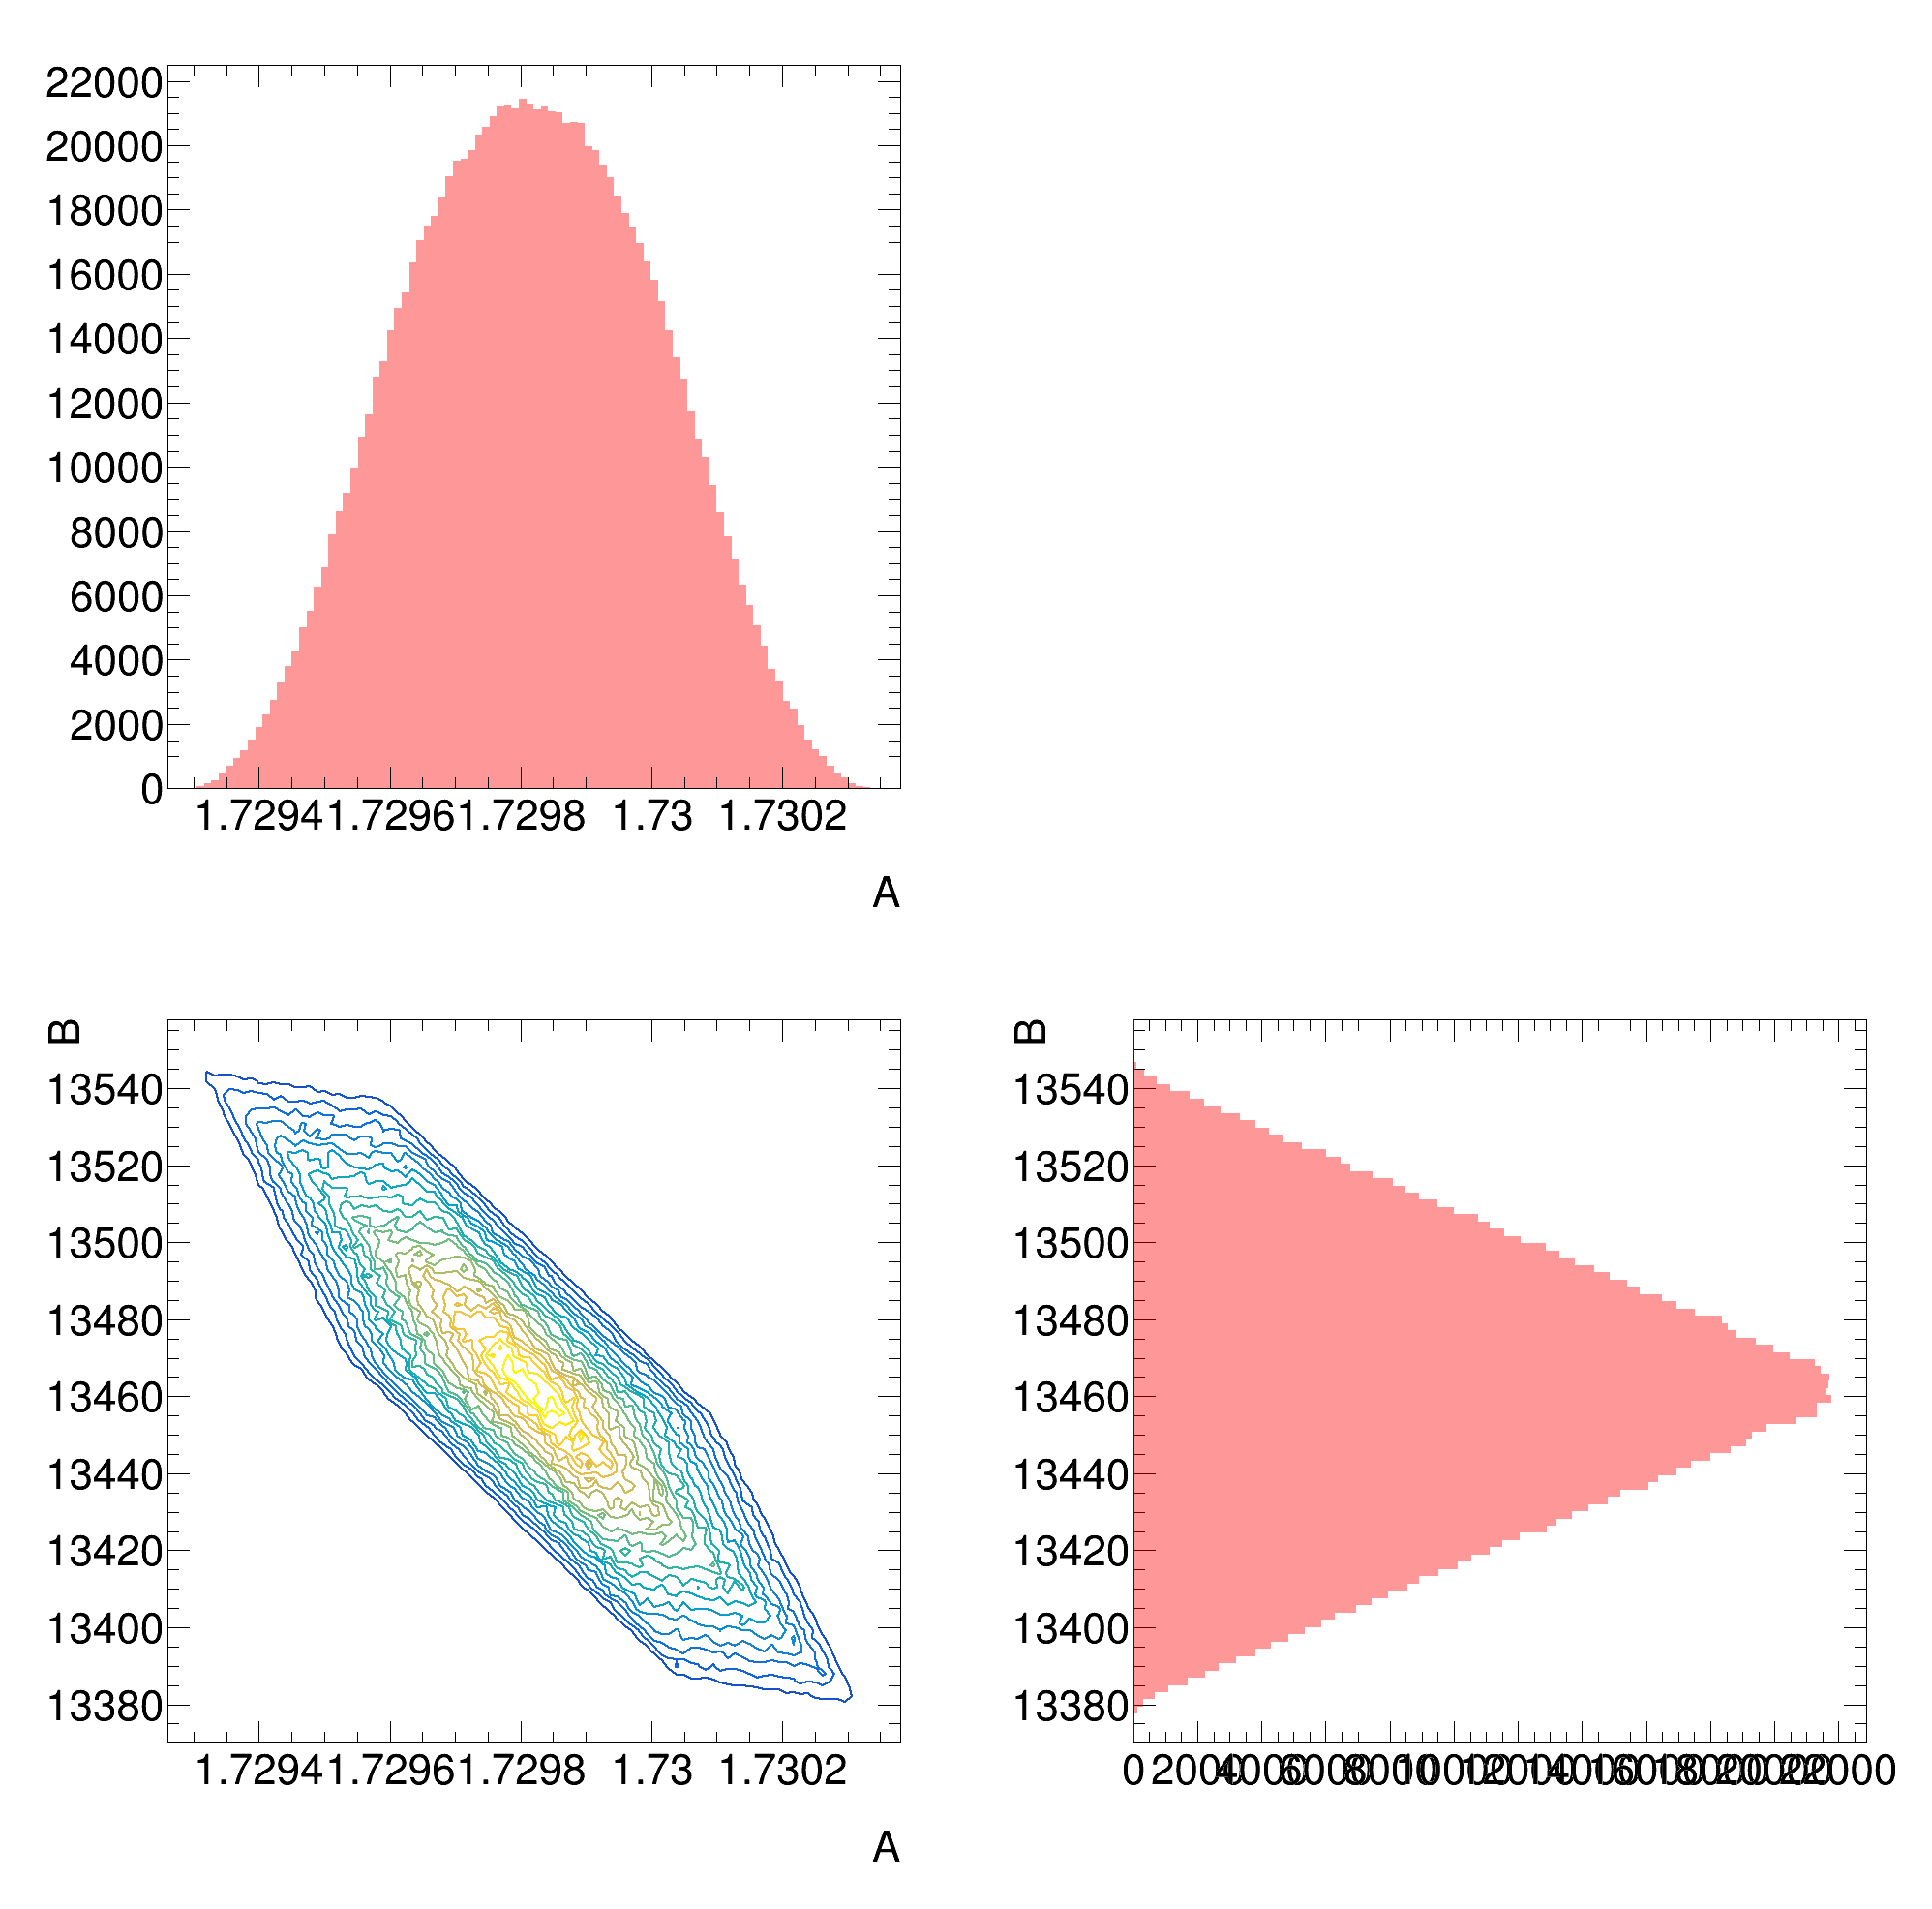

In [11]:
c = ROOT.TCanvas('', '', 2000, 2000)
c.Divide(2,2)
c.cd(3)
hAB.SetTitle(';A;B')
hAB.Draw('CONT1')
c.cd(1)
hA = hAB.ProjectionX()
hA.SetLineColor(ROOT.kRed)
hA.SetFillColorAlpha(ROOT.kRed, 0.4)
hA.Draw('bar')
c.cd(4)
hB = hAB.ProjectionY()
hB.SetLineColor(ROOT.kRed)
hB.SetFillColorAlpha(ROOT.kRed, 0.4)
hB.Draw('hbar')

c.Draw()

In [12]:
print(f'Fattore di correlazione ρ_ij = corr(A, B) = {hAB.GetCorrelationFactor():.5}')

Fattore di correlazione ρ_ij = corr(A, B) = -0.8744


## Correlazione di $n_{1/2}$, correlazione di $\delta_{1/2}$

Vogliamo ora provare a vedere se è presente una sorta di correlazione per i coefficienti $n_i$ di rifrazione e/o per i valori di $\delta_i$. Procediamo allo stesso modo, però considerando questa volta tre diversi istogrammi e ottenendo quindi tre valori di correlazione. 

Considero inizialmente errori $\sigma_\theta$ distribuiti normalemnte. 

Fattore di correlazione ρ_ij = corr(A, B) = -0.87376
Fattore di correlazione ρ_ij = corr(n_1, n_2) = 0.49786
Fattore di correlazione ρ_ij = corr(δ_1, δ_2) = 0.49751


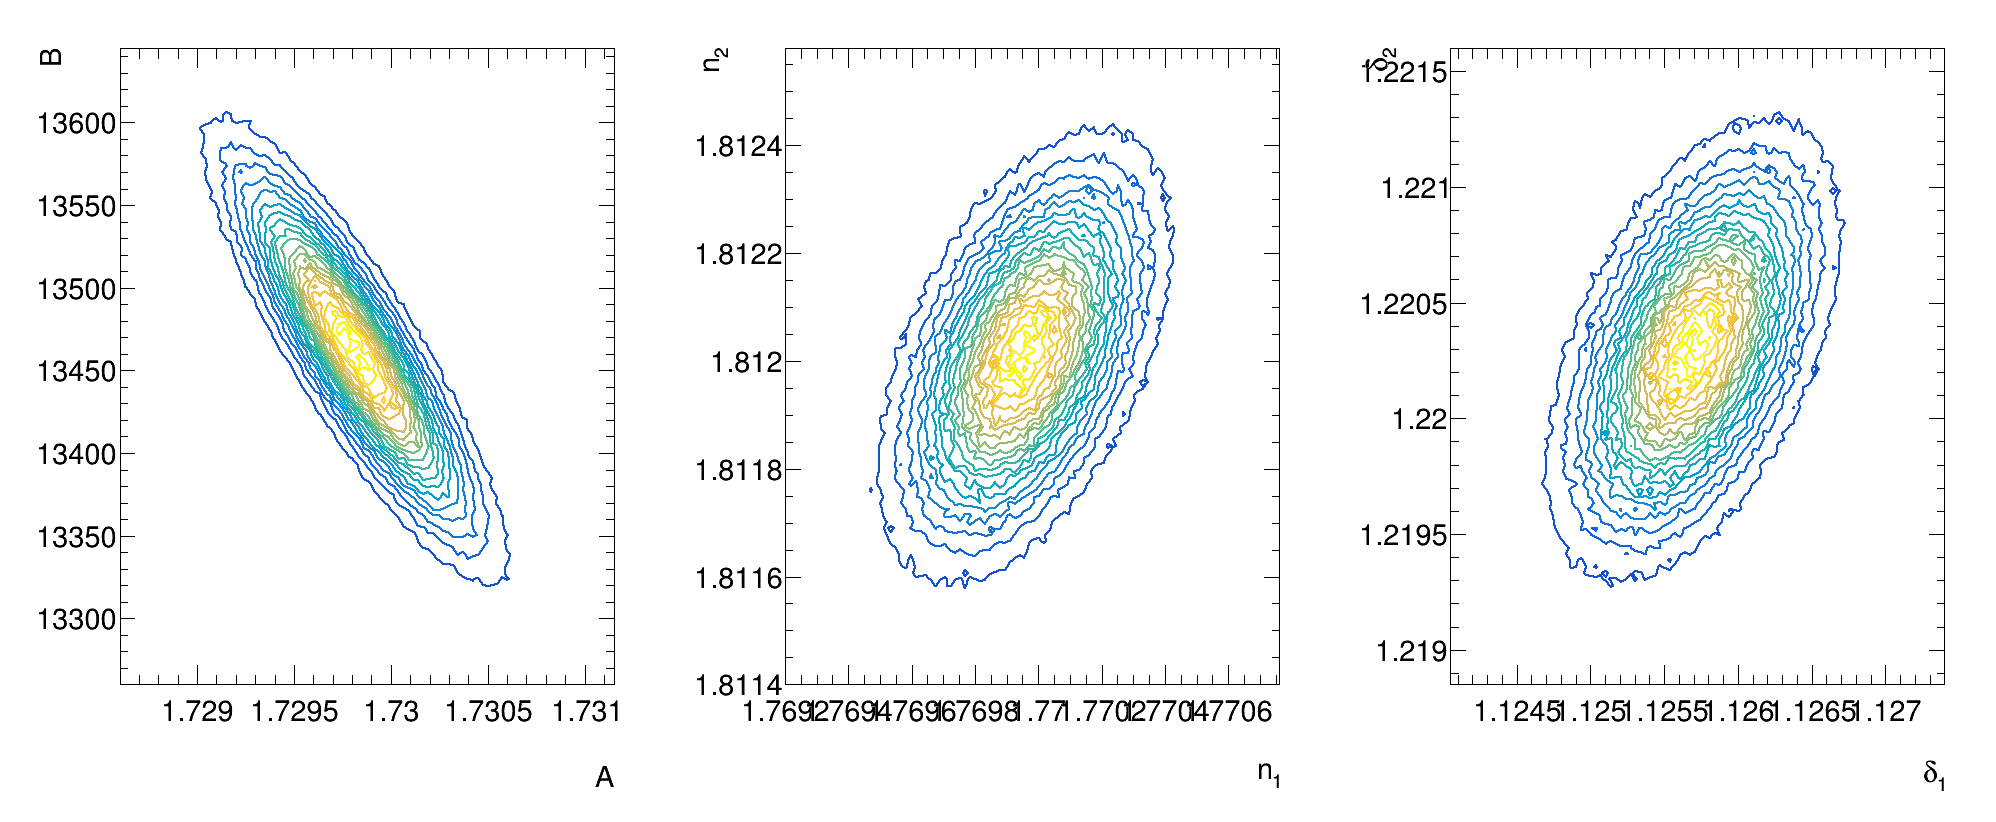

In [13]:
n_samples = 1_000_000

rnd = ROOT.TRandom3(58347942)

hAB = ROOT.TH2D('', '', 100, 0, 0, 100, 0, 0)
hAB.SetTitle('A/B correlation;A;B')
hn1n2 = ROOT.TH2D('', '', 100, 0, 0, 100, 0, 0)
hn1n2.SetTitle('n_{1}/n_{2} correlation;n_{1};n_{2}')
hδ1δ2 = ROOT.TH2D('', '', 100, 0, 0, 100, 0, 0)
hδ1δ2.SetTitle('#delta_{1}/#delta_{2} correlation;#delta_{1};#delta_{2}')

def computeAB(th_0, th_1, th_2):
    
    def n_i(th_i, th_0):
        return np.sin((th_i - th_0 + α)/2)/np.sin(α/2)
    A = (n_i(th_1, th_0)*λ_1**2 - n_i(th_2, th_0)*λ_2**2)/(λ_1**2 - λ_2**2)
    B = (n_i(th_1, th_0) - n_i(th_2, th_0))/(1/(λ_1**2) - 1/(λ_2**2))
    return A, B, n_i(th_1, th_0), n_i(th_2, th_0), th_1-th_0, th_2-th_0

for i in range(n_samples):
    A, B, n_1, n_2, δ_1, δ_2 = computeAB(th_0=rnd.Gaus(θ_0,ε_θ), th_1=rnd.Gaus(θ_1,ε_θ), th_2=rnd.Gaus(θ_2,ε_θ))
    hAB.Fill(A,B)
    hn1n2.Fill(n_1, n_2)
    hδ1δ2.Fill(δ_1, δ_2)

c = ROOT.TCanvas('', '', 2000, 850)
c.Divide(3)

c.cd(1)
hAB.Draw('CONT1')
c.cd(2)
hn1n2.Draw('CONT1')
c.cd(3)
hδ1δ2.Draw('CONT1')

c.Draw()

print(f'Fattore di correlazione ρ_ij = corr(A, B) = {hAB.GetCorrelationFactor():.5}')
print(f'Fattore di correlazione ρ_ij = corr(n_1, n_2) = {hn1n2.GetCorrelationFactor():.5}')
print(f'Fattore di correlazione ρ_ij = corr(δ_1, δ_2) = {hδ1δ2.GetCorrelationFactor():.5}')

Considerando invece distribuzioni uniformi, avremo che otteniamo le seguenti distribuzioni. 

Fattore di correlazione ρ_ij = corr(A, B) = -0.8744
Fattore di correlazione ρ_ij = corr(n_1, n_2) = 0.50076
Fattore di correlazione ρ_ij = corr(δ_1, δ_2) = 0.50077


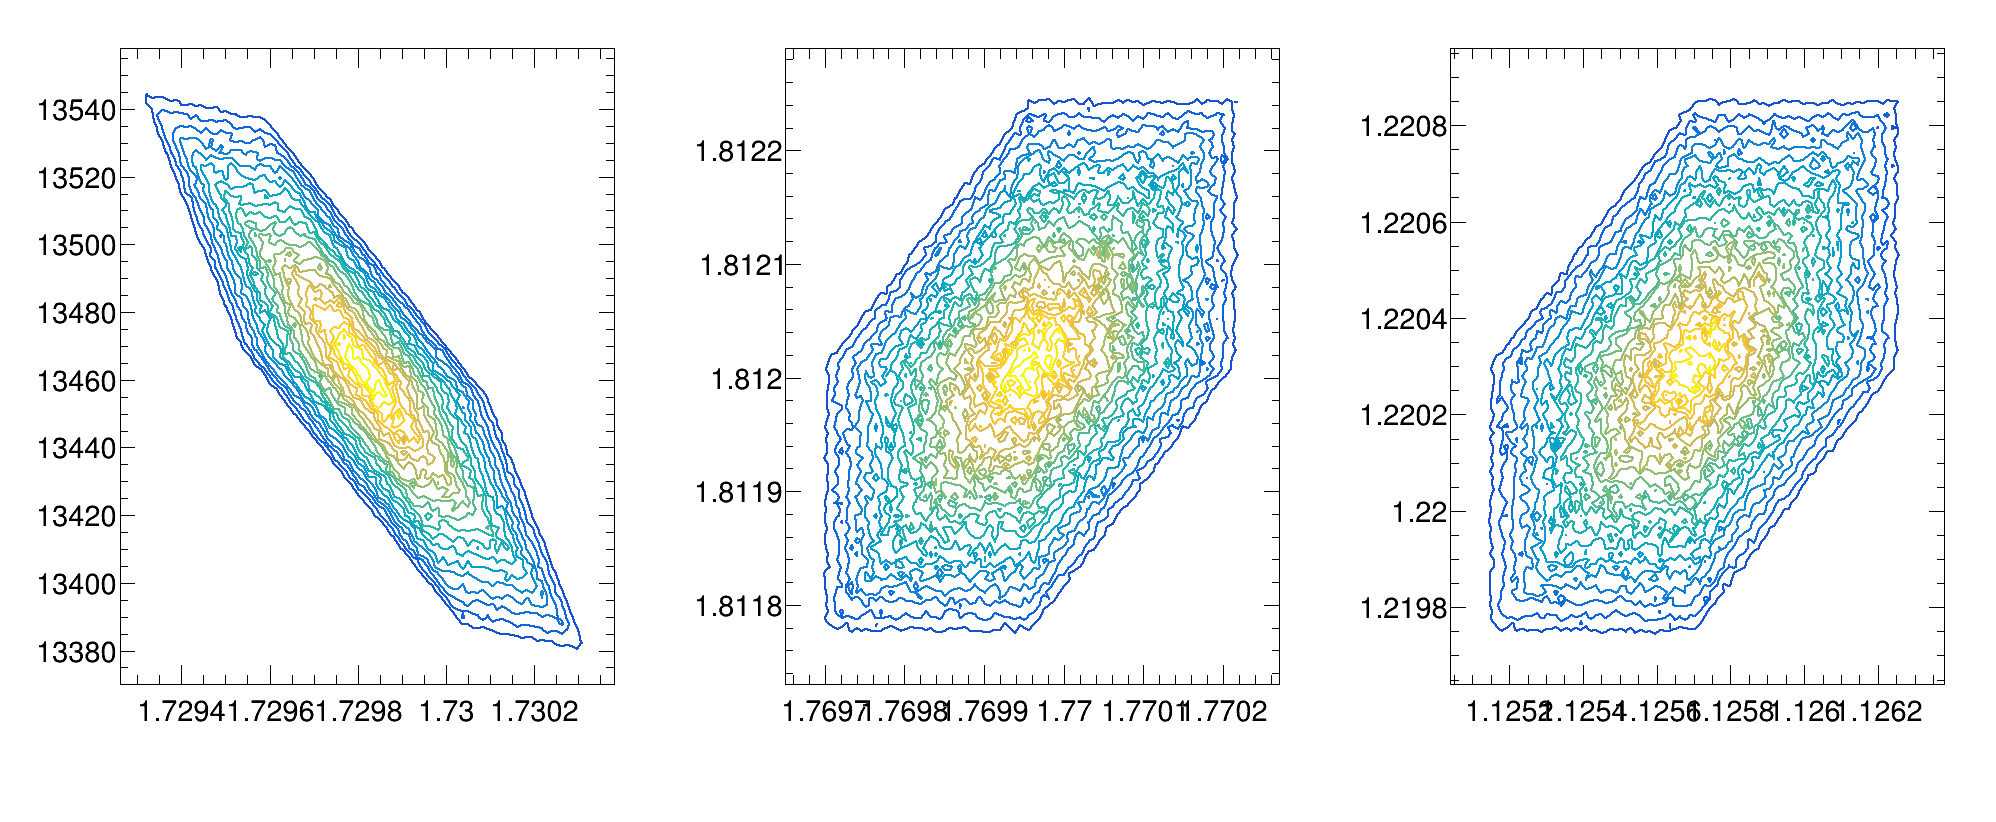

In [14]:
n_samples = 1_000_000

rnd = ROOT.TRandom3(58347942)

hAB = ROOT.TH2D('', '', 100, 0, 0, 100, 0, 0)
hn1n2 = ROOT.TH2D('', '', 100, 0, 0, 100, 0, 0)
hδ1δ2 = ROOT.TH2D('', '', 100, 0, 0, 100, 0, 0)

def computeAB(th_0, th_1, th_2):
    
    def n_i(th_i, th_0):
        return np.sin((th_i - th_0 + α)/2)/np.sin(α/2)
    A = (n_i(th_1, th_0)*λ_1**2 - n_i(th_2, th_0)*λ_2**2)/(λ_1**2 - λ_2**2)
    B = (n_i(th_1, th_0) - n_i(th_2, th_0))/(1/(λ_1**2) - 1/(λ_2**2))
    return A, B, n_i(th_1, th_0), n_i(th_2, th_0), th_1-th_0, th_2-th_0

for i in range(n_samples):
    A, B, n_1, n_2, δ_1, δ_2 = computeAB(th_0=θ_0+ϵ_θ*(2*rnd.Rndm()-1), th_1=θ_1+ϵ_θ*(2*rnd.Rndm()-1), th_2=θ_2+ϵ_θ*(2*rnd.Rndm()-1))
    hAB.Fill(A,B)
    hn1n2.Fill(n_1, n_2)
    hδ1δ2.Fill(δ_1, δ_2)
    
c = ROOT.TCanvas('', '', 2000, 850)
c.Divide(3)

c.cd(1)
hAB.Draw('CONT1')
c.cd(2)
hn1n2.Draw('CONT1')
c.cd(3)
hδ1δ2.Draw('CONT1')

c.Draw()

print(f'Fattore di correlazione ρ_ij = corr(A, B) = {hAB.GetCorrelationFactor():.5}')
print(f'Fattore di correlazione ρ_ij = corr(n_1, n_2) = {hn1n2.GetCorrelationFactor():.5}')
print(f'Fattore di correlazione ρ_ij = corr(δ_1, δ_2) = {hδ1δ2.GetCorrelationFactor():.5}')